## Set up the environment

In [125]:
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from src.plotting import trim_axs
pd.set_option('display.max_rows', None)


In [126]:
import os
os.environ["SUBJECTS_DIR"] = "/Users/emcmaho7/Dropbox/projects/SI_fmri/SIfMRI_modeling/data/raw/freesurfer"
os.environ["FREESURFER_HOME"] = "/Applications/freesurfer"

In [127]:
top_dir = '/Users/emcmaho7/Dropbox/projects/SI_fmri/SIfMRI_modeling'
interim_dir = f'{top_dir}/data/interim'
raw_dir = f'{top_dir}/data/raw'
figure_dir = f'{top_dir}/reports/figures'

## Model comparisons

In [ ]:
import numpy as np
from nilearn import plotting, surface
import nibabel as nib
from src.tools import camera_switcher


def compute_surf_stats(prefix, sub, hemi):
    file = f'{prefix}_hemi-{hemi}.mgz'
    if not os.path.exists(file):
        cmd = '/Applications/freesurfer/bin/mri_vol2surf '
        cmd += f'--src {prefix}.nii.gz '
        cmd += f'--out {file} '
        cmd += f'--regheader sub-{sub} '
        cmd += f'--hemi {hemi} '
        cmd += '--projfrac 1'
        os.system(cmd)
    return surface.load_surf_data(file)


def load_surf_mesh(path, sub, hemi):
    return f'{path}/freesurfer/sub-{sub}/surf/{hemi}.inflated', \
            f'{path}/freesurfer/sub-{sub}/surf/{hemi}.sulc'


def plot_stats(surf_mesh, bg_map, surf_map, hemi_, figure_prefix,
                vmax=0.6, vmin=None, cmap=sns.color_palette('magma', as_cmap=True)):
    if vmin is not None:
        threshold = None
    else:
        threshold = 1e-3

    if hemi_ == 'lh':
        hemi_name = 'left'
    else:
        hemi_name = 'right'

    surf_map = np.nan_to_num(surf_map)
    if vmin is None or vmin > 0:
        surf_map[surf_map < 0] = 0

    fig = plotting.plot_surf_roi(surf_mesh=surf_mesh,
                                    roi_map=surf_map,
                                    bg_map=bg_map,
                                    threshold=threshold,
                                    vmin=vmin,
                                    vmax=vmax,
                                    engine='plotly',
                                    colorbar=True,
                                    cmap=cmap,
                                    hemi=hemi_name)
    fig.figure.write_html(f'{figure_prefix}_hemi-{hemi_}.html')

    # for view in ['ventral', 'lateral', 'medial']:
    #     colorbar = True if view == 'medial' and hemi_ == 'rh' else False
    #     fig = plotting.plot_surf_roi(surf_mesh=surf_mesh,
    #                                     roi_map=surf_map,
    #                                     bg_map=bg_map,
    #                                     threshold=threshold,
    #                                     vmin=vmin, 
    #                                     vmax=vmax,
    #                                     engine='plotly',
    #                                     colorbar=colorbar,
    #                                     view=view,
    #                                     cmap=cmap,
    #                                     hemi=hemi_name)
    #     fig.figure.update_layout(scene_camera=camera_switcher(hemi_, view),
    #                                 paper_bgcolor="rgba(0,0,0,0)",
    #                                 plot_bgcolor="rgba(0,0,0,0)")
    #     fig.figure.write_image(f'{figure_prefix}_view-{view}_hemi-{hemi_}.png')


In [129]:
scores = []

# files = glob(f'{interim_dir}/VisionEncoding/*.csv')
# for file in files:
#     df = pd.read_csv(file)
#     df['model_uid'] = file.split('/')[-1].split('.csv')[0].split('model-')[-1]
#     scores.append(df)

files = glob(f'{interim_dir}/LLMEncoding/*corrected_unmasked.csv')
for file in files:
    df = pd.read_csv(file)
    df['model_uid'] = file.split('/')[-1].split('.csv')[0].split('_perturb')[0].split('model-')[-1]
    scores.append(df)
    
scores = pd.concat(scores).reset_index(drop=True)
scores.head()

,voxel_id,roi_name,stream_name,subj_id,reliability,i_index,j_index,k_index,layer_index,layer,score,model_uid
0,0,none,none,1,0.322961,2,33,31,1,BertModel-S1,0.155465,all-MiniLM-L6-v2
1,1,none,none,1,0.340669,2,33,32,1,BertModel-S1,0.219018,all-MiniLM-L6-v2
2,2,none,none,1,0.313496,2,34,35,1,BertModel-S1,0.172941,all-MiniLM-L6-v2
3,3,none,none,1,0.254933,2,35,31,1,BertModel-S1,0.062269,all-MiniLM-L6-v2
4,4,none,none,1,0.300477,2,36,36,1,BertModel-S1,0.188886,all-MiniLM-L6-v2


In [ ]:
for subj_id in range(1,5):
    for model in ['all-MiniLM-L6-v2', 'slip_vit_s_simclr_yfcc15m']:
        subj_id_str = str(subj_id).zfill(2)
        stat_file = f'{interim_dir}/Plotting/sub-{subj_id_str}_model-{model}'
        plot_file = f'{figure_dir}/Plotting/sub-{subj_id_str}_model-{model}'

        img = nib.load(f'{raw_dir}/fmri_betas/sub-{subj_id_str}_space-T1w_desc-train-fracridge_data.nii.gz')

        dims = img.shape[:-1]
        header, affine = img.header, img.affine

        cur_df = scores.loc[(scores.model_uid == model) & (scores.subj_id == subj_id)]
        scores_arr = cur_df['score'].to_numpy()
        indices = cur_df[['i_index', 'j_index', 'k_index']].to_numpy()

        score_img = np.zeros(dims)
        score_img[indices[:, 0], indices[:, 1], indices[:, 2]] = scores_arr
        score_img = nib.Nifti1Image(score_img, affine=affine, header=header)
        nib.save(score_img, f'{stat_file}.nii.gz')

        for hemi in ['lh', 'rh']:
            surf = compute_surf_stats(stat_file, subj_id_str, hemi)
            inflated, sulcus = load_surf_mesh(raw_dir, subj_id_str, hemi)
            plot_stats(inflated, sulcus, surf, hemi, plot_file)

/Applications/anaconda3/envs/fmri_modeling/lib/python3.10/site-packages/nilearn/plotting/js_plotting_utils.py:85: UserWarning:

choosing both vmin and a threshold is not allowed; setting vmin to 0

/Applications/anaconda3/envs/fmri_modeling/lib/python3.10/site-packages/nilearn/plotting/js_plotting_utils.py:85: UserWarning:

choosing both vmin and a threshold is not allowed; setting vmin to 0

/Applications/anaconda3/envs/fmri_modeling/lib/python3.10/site-packages/nilearn/plotting/js_plotting_utils.py:85: UserWarning:

choosing both vmin and a threshold is not allowed; setting vmin to 0

/Applications/anaconda3/envs/fmri_modeling/lib/python3.10/site-packages/nilearn/plotting/js_plotting_utils.py:85: UserWarning:

choosing both vmin and a threshold is not allowed; setting vmin to 0

/Applications/anaconda3/envs/fmri_modeling/lib/python3.10/site-packages/nilearn/plotting/js_plotting_utils.py:85: UserWarning:

choosing both vmin and a threshold is not allowed; setting vmin to 0

/Applicati

In [ ]:
vm = 'slip_vit_s_simclr_yfcc15m'
lm = 'all-MiniLM-L6-v2'

for subj_id in range(1,5):
    subj_id_str = str(subj_id).zfill(2)
    stat_file = f'{interim_dir}/Plotting/sub-{subj_id_str}_model-visminuslang'
    plot_file = f'{figure_dir}/Plotting/sub-{subj_id_str}_model-visminuslang'

    img = nib.load(f'{raw_dir}/fmri_betas/sub-{subj_id_str}_space-T1w_desc-train-fracridge_data.nii.gz')

    dims = img.shape[:-1]
    header, affine = img.header, img.affine

    vision_df = scores.loc[(scores.model_uid == vm) & (scores.subj_id == subj_id)]
    language_df = scores.loc[(scores.model_uid == lm) & (scores.subj_id == subj_id)]
    scores_arr = vision_df['score'].to_numpy() - language_df['score'].to_numpy()
    indices = vision_df[['i_index', 'j_index', 'k_index']].to_numpy()

    score_img = np.zeros(dims)
    score_img[indices[:, 0], indices[:, 1], indices[:, 2]] = scores_arr
    score_img = nib.Nifti1Image(score_img, affine=affine, header=header)
    nib.save(score_img, f'{stat_file}.nii.gz')

    for hemi in ['lh', 'rh']:
        surf = compute_surf_stats(stat_file, subj_id_str, hemi)
        inflated, sulcus = load_surf_mesh(raw_dir, subj_id_str, hemi)
        plot_stats(inflated, sulcus, surf, hemi, plot_file, vmax=.6, vmin=-.6,
                    cmap=sns.color_palette('icefire', as_cmap=True))

/Applications/anaconda3/envs/fmri_modeling/lib/python3.10/site-packages/nilearn/plotting/js_plotting_utils.py:76: UserWarning:

you have specified symmetric_cmap=False but the map contains negative values; setting symmetric_cmap to True

/Applications/anaconda3/envs/fmri_modeling/lib/python3.10/site-packages/nilearn/plotting/js_plotting_utils.py:81: UserWarning:

vmin cannot be chosen when cmap is symmetric

/Applications/anaconda3/envs/fmri_modeling/lib/python3.10/site-packages/nilearn/plotting/js_plotting_utils.py:76: UserWarning:

you have specified symmetric_cmap=False but the map contains negative values; setting symmetric_cmap to True

/Applications/anaconda3/envs/fmri_modeling/lib/python3.10/site-packages/nilearn/plotting/js_plotting_utils.py:81: UserWarning:

vmin cannot be chosen when cmap is symmetric

/Applications/anaconda3/envs/fmri_modeling/lib/python3.10/site-packages/nilearn/plotting/js_plotting_utils.py:76: UserWarning:

you have specified symmetric_cmap=False but the 

In [136]:
avg_stream_scores.head(20)

,stream_name,model_uid,subj_id,voxel_id,reliability,i_index,j_index,k_index,layer_index,score
0,EVC,all-MiniLM-L6-v2,1,17455.485280,0.532916,34.498575,9.261159,31.572016,1.0,0.195813
1,EVC,all-MiniLM-L6-v2,2,62930.802511,0.626816,35.372015,10.344764,27.369565,1.0,0.223627
2,EVC,all-MiniLM-L6-v2,3,108934.681596,0.586891,33.484640,10.972150,24.384439,1.0,0.196046
3,EVC,all-MiniLM-L6-v2,4,155280.488002,0.624559,36.880020,10.899470,27.720131,1.0,0.190183
4,mid_ventral,all-MiniLM-L6-v2,1,19406.724422,0.478036,37.440594,10.264026,25.158416,1.0,0.221017
5,mid_ventral,all-MiniLM-L6-v2,2,64348.072993,0.524232,36.912409,12.475912,21.865693,1.0,0.216183
6,mid_ventral,all-MiniLM-L6-v2,3,111053.400697,0.594507,35.708479,15.128920,20.084785,1.0,0.248657
7,mid_ventral,all-MiniLM-L6-v2,4,157588.070196,0.528158,39.762946,13.416571,21.323360,1.0,0.215915
8,mid_lateral,all-MiniLM-L6-v2,1,15854.222698,0.423116,32.154176,10.034261,31.379015,1.0,0.224085
9,mid_lateral,all-MiniLM-L6-v2,2,60534.550077,0.516736,32.892142,10.756549,27.881356,1.0,0.213702


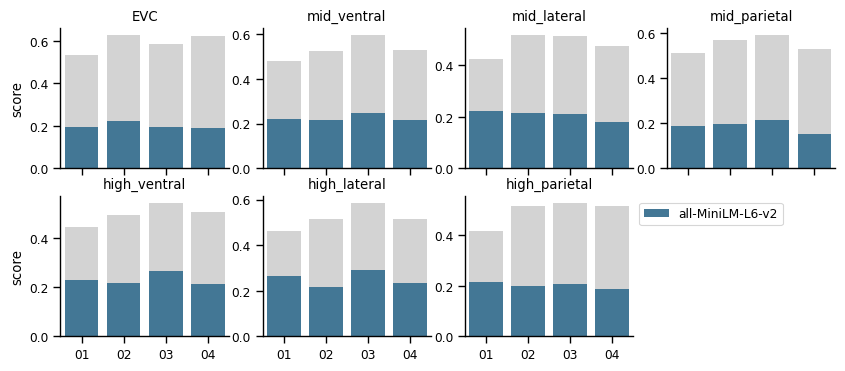

In [135]:
streams = ['EVC']
streams += [f'{level}_{stream}' for level in ['mid', 'high'] for stream in ['ventral', 'lateral', 'parietal']]
stream_scores = scores.loc[scores.stream_name != 'none'].reset_index(drop=True)
cat_type = pd.CategoricalDtype(categories=streams, ordered=True)
stream_scores['stream_name'] = stream_scores['stream_name'].astype(cat_type)
avg_stream_scores = stream_scores.groupby(['stream_name', 'model_uid', 'subj_id']).mean(numeric_only=True).reset_index()

sns.set_context(context='paper')
_, axes = plt.subplots(2, 4, sharex=True, figsize=(10, 4))
trim_axs(axes, len(streams))
axes = axes.flatten()
stream_group = avg_stream_scores.groupby('stream_name')
subjs = ['01', '02', '03', '04']
for ax, (stream, stream_df) in zip(axes, stream_group):
   sns.barplot(x='subj_id', y='reliability', color='lightgray',
               data=stream_df, ax=ax, errorbar=None,
               zorder=0)
   sns.barplot(x='subj_id', y='score',
               hue='model_uid', palette='mako',
                  data=stream_df, ax=ax, errorbar=None,
                  zorder=1)
   if stream not in ['EVC', 'high_ventral']:
         ax.set_ylabel('')
   ax.spines['top'].set_visible(False)
   ax.spines['right'].set_visible(False)
   ax.set_xticklabels(subjs, ha='center')
   ax.set_title(stream)
   ax.set_xlabel('')
   if stream != 'high_parietal':
      ax.legend().set_visible(False)
   else:
      ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.tight_layout()

In [ ]:
roi_scores.loc[roi_scores.]

voxel_id  reliability    i_index    j_index  \
subj_id roi_name                                                      
1       EVC         17453.304046     0.532758  34.495259   9.259798   
        MT          19466.051282     0.509130  37.316239  16.512821   
        FFA         19744.272727     0.621485  37.651515  24.378788   
        PPA         17484.389610     0.509204  33.922078  30.675325   
        LOC         17387.647661     0.590025  34.089181  19.201754   
        pSTS        16029.587302     0.513436  31.940476  27.654762   
        face-pSTS   31387.416667     0.531759  55.548611  33.083333   
        aSTS        20942.910615     0.496156  38.905028  47.223464   
2       EVC         62925.538556     0.626767  35.366279  10.345471   
        MT          64402.916031     0.664509  37.038168  16.938931   
        FFA         68923.182609     0.676043  41.826087  25.339130   
        PPA         62331.567901     0.601146  34.172840  32.172840   
        LOC         63016.837313     0.635699  35.501493  20.059701   
        pSTS        59786.772871     0.584105  31.835962  25.227129   
        face-pSTS   77929.777778     0.588155  52.038889  28.655556   
        aSTS        70413.870588     0.550443  43.505882  44.952941   
3       EVC        108935.916094     0.587085  33.485395  10.975086   
        MT         114349.568345     0.750183  39.557554  17.985612   
        FFA        116043.294521     0.742644  41.397260  30.198630   
        PPA        110174.284211     0.570793  34.168421  35.915789   
        LOC        110532.509299     0.626362  34.821173  20.703863   
        pSTS       111832.206140     0.633759  36.385965  26.991228   
        face-pSTS  118816.582609     0.718559  44.847826  31.317391   
        aSTS       112375.890244     0.574330  36.628049  52.451220   
4       EVC        155281.271810     0.624507  36.880988  10.900403   
        MT         161340.015038     0.558587  44.443609  15.842105   
        FFA        162570.305970     0.601369  45.828358  33.380597   
        PPA        153175.479167     0.649433  33.645833  32.552083   
        LOC        154582.252014     0.621118  35.420023  19.171461   
        pSTS       151135.927114     0.536300  30.145773  27.857143   
        face-pSTS  166592.835391     0.591074  50.880658  28.975309   
        aSTS       160941.717391     0.458872  43.188406  49.384058   

                     k_index  layer_index     score  
subj_id roi_name                                     
1       EVC        31.561631          1.0  0.340052  
        MT         33.393162          1.0  0.282252  
        FFA        22.795455          1.0  0.364353  
        PPA        25.844156          1.0  0.421032  
        LOC        29.416667          1.0  0.338668  
        pSTS       35.777778          1.0  0.198553  
        face-pSTS  31.756944          1.0  0.247299  
        aSTS       24.893855          1.0  0.232345  
2       EVC        27.365667          1.0  0.390728  
        MT         31.335878          1.0  0.290959  
        FFA        22.147826          1.0  0.412967  
        PPA        26.098765          1.0  0.363357  
        LOC        27.922388          1.0  0.308187  
        pSTS       36.388013          1.0  0.211658  
        face-pSTS  36.083333          1.0  0.223627  
        aSTS       31.311765          1.0  0.235118  
3       EVC        24.368843          1.0  0.369403  
        MT         29.338129          1.0  0.346902  
        FFA        21.102740          1.0  0.504371  
        PPA        27.073684          1.0  0.374898  
        LOC        25.360515          1.0  0.319660  
        pSTS       35.289474          1.0  0.250733  
        face-pSTS  34.213043          1.0  0.357252  
        aSTS       31.701220          1.0  0.264035  
4       EVC        27.708018          1.0  0.386682  
        MT         31.473684          1.0  0.262987  
        FFA        21.164179          1.0  0.270016  
        PPA        27.114583          1.0  

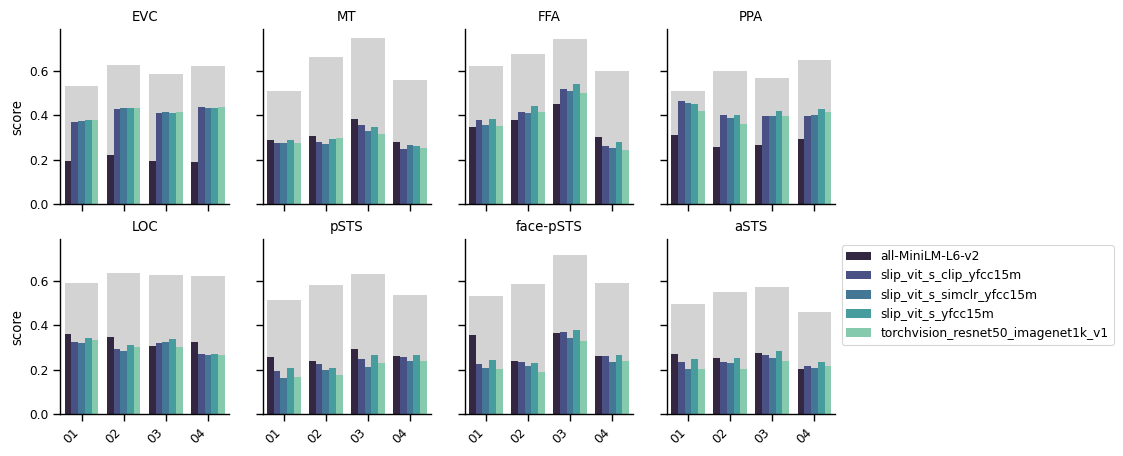

In [ ]:
rois = ['EVC', 'MT', 'FFA', 'PPA', 'LOC', 'pSTS', 'face-pSTS', 'aSTS']
roi_scores = scores.loc[scores.roi_name != 'none'].reset_index(drop=True)
cat_type = pd.CategoricalDtype(categories=rois, ordered=True)
roi_scores['roi_name'] = roi_scores['roi_name'].astype(cat_type)
avg_roi_scores = roi_scores.groupby(['roi_name', 'model_uid', 'subj_id']).mean(numeric_only=True).reset_index()

sns.set_context(context='paper')
_, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(10, 5))
axes = axes.flatten()
roi_group = avg_roi_scores.groupby('roi_name')
subjs = ['01', '02', '03', '04']
for ax, (roi, roi_df) in zip(axes, roi_group):
   sns.barplot(x='subj_id', y='reliability', color='lightgray',
               data=roi_df, ax=ax, errorbar=None,
               zorder=0)
   sns.barplot(x='subj_id', y='score',
               hue='model_uid', palette='mako',
                  data=roi_df, ax=ax, errorbar=None,
                  zorder=1)
   if roi not in ['EVC', 'LOC']:
      ax.set_ylabel('')
   ax.spines['top'].set_visible(False)
   ax.spines['right'].set_visible(False)
   ax.set_xticklabels(subjs, rotation=45, ha='right')
   ax.set_title(roi)
   ax.set_xlabel('')
   if roi != 'aSTS':
      ax.legend().set_visible(False)
   else:
      ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.tight_layout()

## SBERT perturbation experiments

In [ ]:
perturbations = ['none', 'corrected_unmasked', 'shuffle_sentence', 
                'mask_all_nouns', 'mask_all_verbs',
                'mask_main_subjects', 'mask_main_verb_phrase', 
                'mask_direct_objects', 'mask_prep_phrases']

In [ ]:
scores = []
for perturb in perturbations:
    file = f'{interim_dir}/LLMEncoding/model-all-MiniLM-L6-v2_perturbation-{perturb}.csv'
    df = pd.read_csv(file)
    df['perturbation'] = perturb
    scores.append(df)
    
scores = pd.concat(scores).reset_index(drop=True)
scores = scores[scores['stream_name'] != 'none'].reset_index(drop=True)
scores['model_layer_index'] = scores.model_layer_index.astype('str')
scores.set_index(['perturbation', 'model_layer_index', 'stream_name'], inplace=True)
scores.sort_index(inplace=True)
scores.head()

model_layer  subj_id  \
perturbation       model_layer_index stream_name                           
corrected_unmasked 1                 EVC           BertModel-S1        1   
                                     EVC           BertModel-S1        2   
                                     EVC           BertModel-S1        3   
                                     EVC           BertModel-S1        4   
                                     high_lateral  BertModel-S1        1   

                                                      score method  
perturbation       model_layer_index stream_name                    
corrected_unmasked 1                 EVC           0.045357  ridge  
                                     EVC           0.096012  ridge  
                                     EVC           0.068637  ridge  
                                     EVC           0.054093  ridge  
                                     high_lateral  0.134146  ridge

In [ ]:
avg_scores = scores.reset_index().groupby(['perturbation', 'model_layer_index', 'stream_name']).mean().reset_index()
iter_scores = avg_scores.groupby(['perturbation', 'stream_name'])
max_scores = []
for (model_uid, stream), stream_df in iter_scores:
    idx = stream_df['score'].idxmax()
    score = tuple(stream_df.loc[idx, ['perturbation', 'model_layer_index', 'stream_name']].to_list())
    max_scores.append(scores.loc[score])
max_scores = pd.concat(max_scores).reset_index()
max_scores.head()

/var/folders/bp/2lmtx6qs4rzbksq18mtrbrjsfr_flb/T/ipykernel_24860/37540273.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_scores = scores.reset_index().groupby(['perturbation', 'model_layer_index', 'stream_name']).mean().reset_index()


,perturbation,model_layer_index,stream_name,model_layer,subj_id,score,method
0,corrected_unmasked,91,EVC,LayerNorm-6-35,1,0.076571,ridge
1,corrected_unmasked,91,EVC,LayerNorm-6-35,2,0.103687,ridge
2,corrected_unmasked,91,EVC,LayerNorm-6-35,3,0.091580,ridge
3,corrected_unmasked,91,EVC,LayerNorm-6-35,4,0.084788,ridge
4,corrected_unmasked,92,high_lateral,BertIntermediate-4-14,1,0.166583,ridge


In [ ]:
cat_type = pd.CategoricalDtype(categories=streams, ordered=True)
max_scores['stream_name'] = max_scores['stream_name'].astype(cat_type)

cat_type = pd.CategoricalDtype(categories=perturbations, ordered=True)
max_scores['perturbation'] = max_scores['perturbation'].astype(cat_type)

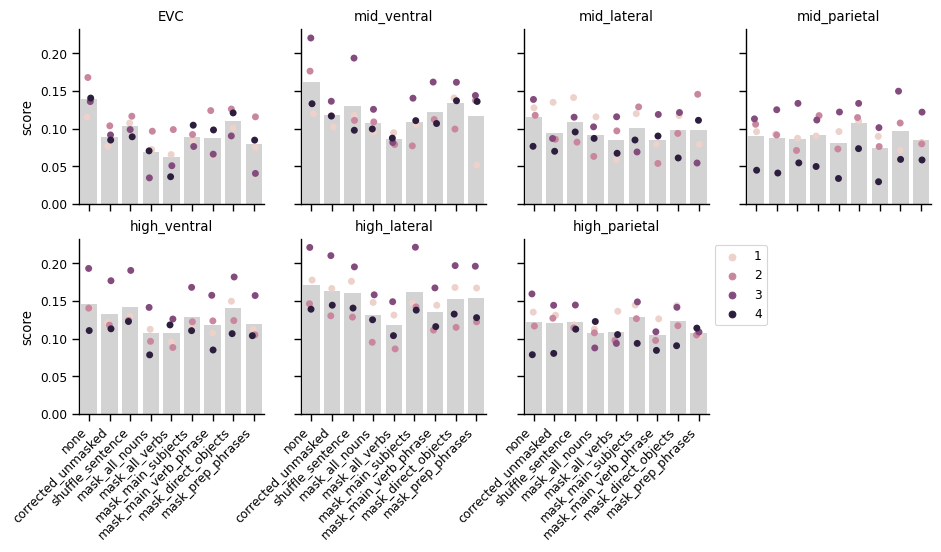

In [ ]:
sns.set_context(context='paper')
_, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(11,5))
trim_axs(axes, len(streams))
axes = axes.flatten()
stream_group = max_scores.groupby('stream_name')
for ax, (stream, stream_df) in zip(axes, stream_group):
   sns.barplot(x='perturbation', y='score',
                  data=stream_df, ax=ax,
                  color='lightgray', errorbar=None)
   sns.stripplot(x='perturbation', y='score',
                  hue='subj_id', dodge=False,
                  data=stream_df, ax=ax)
   if stream not in ['EVC', 'high_ventral']:
         ax.set_ylabel('')
   ax.spines['top'].set_visible(False)
   ax.spines['right'].set_visible(False)
   ax.set_xticklabels(perturbations, rotation=45, ha='right')
   ax.set_title(stream)
   ax.set_xlabel('')
   if stream != 'high_parietal':
      ax.legend().set_visible(False)
   else:
      ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.tight_layout()